In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import scipy
import scipy.stats as stats
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train = pd.read_csv('/Users/Albert/Desktop/Thinkful_Drills/Data/Capstone Datasets/Criteo - Click Rate Prediction Data/Criteo Click Rate Prediction (Train).txt', sep='\t')

Today we'll be diving into the world of digital advertising, specifically looking at Criteo's ad click and impression data. This dataset contains feature values and click feedback for millions of display ads, consisting of a subsample of Criteo's traffic over a period of 7 days. Each sample/row corresponds to a display ad served by Criteo.

In [ ]:
train.head()

As you can see, we're dealing with a pretty messy dataset. Let's see what we can do to tidy it up.

# Data Cleaning

### Subsampling

In [ ]:
train.shape

In [ ]:
train.iloc[:,0].value_counts(normalize=True)

First off, the dataset is massive. There are over 45 million samples. Let's snip off a more manageable chunk to manipulate and explore.

Normally we'd look to oversample here since clicks are so much more unlikely than non-clicks. Luckily, the editors of the dataset have already done so and provided us with a nice split of 25% clicked and 75% not clicked. We'll take it from there and grab a subsample of that.

In [ ]:
subsample = train.sample(frac=.01, axis=0)
subsample.shape

With a little over 450,000 samples that's a much more manageable dataset. We'll also take our subsample, export it to CSV and come back to it later to conserve some RAM for some of our more intensive functions later.b

In [ ]:
subsample.to_csv('/Users/Albert/Desktop/Criteo Subsample')

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import scipy
import scipy.stats as stats
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

subsample = pd.read_csv('/Users/Albert/Desktop/Criteo Subsample')
subsample = subsample.set_index(subsample.columns[0])
subsample.head()

,0,1,1.1,5,0.1,1382,4,15,2,181,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,Unnamed: 35,3a171ecb,c5c50484,e8b83407,9727dd16
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
36232316,0,NaN,10,16.0,12.0,7699.0,64.0,22.0,29.0,63.0,...,e5ba7672,775e80fe,21ddcdc9,5840adea,3ee29a07,NaN,32c7478e,c83e0347,ea9a246c,2fede552
21296210,0,3.0,18,7.0,5.0,1425.0,30.0,18.0,21.0,24.0,...,e5ba7672,065917ca,NaN,NaN,aa65f24c,NaN,32c7478e,1b792862,NaN,NaN
29861623,0,0.0,6,NaN,NaN,16005.0,NaN,0.0,5.0,10.0,...,07c540c4,6fba30f8,NaN,NaN,122d6055,NaN,32c7478e,d8e17d82,NaN,NaN
2180039,0,2.0,180,60.0,20.0,57.0,19.0,34.0,47.0,198.0,...,e5ba7672,2804effd,NaN,NaN,723b4dfd,ad3062eb,32c7478e,b34f3128,NaN,NaN
7964721,0,NaN,90,25.0,3.0,8462.0,NaN,0.0,5.0,38.0,...,776ce399,d632055f,21ddcdc9,5840adea,3dd38d65,NaN,be7c41b4,c2fe6ca4,001f3601,c3546e32


### Renaming

Secondly, there are no naming conventions. We won't know any of the specific values, but we do have some details about what the columns contain:

- 1 outcome variable: whether a user clicked the ad or not
- 13 continuous features
- 26 categorical features

Let's make these adjustments in the data.

In [2]:
new_col_names = ['click']

cont_names = ['cont_{}'.format(i) for i in range(1,14)]
new_col_names.extend(cont_names)

catg_names = ['catg_{}'.format(i) for i in range(1,27)]
new_col_names.extend(catg_names)


rename_dict = {}

for current, new in zip (subsample.columns, new_col_names):
    rename_dict[current] = new

In [3]:
rename_dict

{'0': 'click',
 '0.1': 'cont_4',
 '07b5194c': 'catg_21',
 '1': 'cont_1',
 '1.1': 'cont_2',
 '1.2': 'cont_10',
 '1382': 'cont_5',
 '15': 'cont_7',
 '181': 'cont_9',
 '1adce6ef': 'catg_14',
 '1f89b562': 'catg_8',
 '2': 'cont_8',
 '2.1': 'cont_11',
 '2.2': 'cont_13',
 '21ddcdc9': 'catg_19',
 '25c83c98': 'catg_5',
 '2824a5f6': 'catg_13',
 '37c9c164': 'catg_12',
 '3a171ecb': 'catg_23',
 '4': 'cont_6',
 '5': 'cont_3',
 '68fd1e64': 'catg_1',
 '7b4723c4': 'catg_4',
 '7e0ccccf': 'catg_6',
 '80e26c9b': 'catg_2',
 '891b62e7': 'catg_16',
 '8ba8b39a': 'catg_15',
 '9727dd16': 'catg_26',
 'Unnamed: 12': 'cont_12',
 'Unnamed: 35': 'catg_22',
 'a73ee510': 'catg_9',
 'a8cd5504': 'catg_10',
 'b1252a9d': 'catg_20',
 'b2cb9c98': 'catg_11',
 'c5c50484': 'catg_24',
 'de7995b8': 'catg_7',
 'e5ba7672': 'catg_17',
 'e8b83407': 'catg_25',
 'f54016b9': 'catg_18',
 'fb936136': 'catg_3'}

In [4]:
subsample = subsample.rename(columns=rename_dict)
unedited = subsample[:]
subsample.columns

Index(['click', 'cont_1', 'cont_2', 'cont_3', 'cont_4', 'cont_5', 'cont_6',
       'cont_7', 'cont_8', 'cont_9', 'cont_10', 'cont_11', 'cont_12',
       'cont_13', 'catg_1', 'catg_2', 'catg_3', 'catg_4', 'catg_5', 'catg_6',
       'catg_7', 'catg_8', 'catg_9', 'catg_10', 'catg_11', 'catg_12',
       'catg_13', 'catg_14', 'catg_15', 'catg_16', 'catg_17', 'catg_18',
       'catg_19', 'catg_20', 'catg_21', 'catg_22', 'catg_23', 'catg_24',
       'catg_25', 'catg_26'],
      dtype='object')

### Null Values

In [5]:
subsample.isnull().sum()

click           0
cont_1     207507
cont_2          0
cont_3      98765
cont_4      99696
cont_5      11709
cont_6     101810
cont_7      19902
cont_8        239
cont_9      19902
cont_10    207507
cont_11     19902
cont_12    350169
cont_13     99696
catg_1          0
catg_2          0
catg_3      15383
catg_4      15383
catg_5          0
catg_6      55186
catg_7          0
catg_8          0
catg_9          0
catg_10         0
catg_11         0
catg_12     15383
catg_13         0
catg_14         0
catg_15         0
catg_16     15383
catg_17         0
catg_18         0
catg_19    201691
catg_20    201691
catg_21     15383
catg_22    349536
catg_23         0
catg_24     15383
catg_25    201691
catg_26    201691
dtype: int64

And finally, perhaps the most frustrating caveat of this dataset: null values. There are a ton of 'em, and the lack of metadata for our features makes those values that much more difficult to intelligently fill in.

To start with we'll simply remove all features with over 200,000 null values. With that many null values imputation is difficult and the features are virtually useless.

*The one exception* is when using Naive Bayes. We'll set aside a subsample with those features retained for our Naive Bayes model analysis. 

In [6]:
# Looping through total null values by column and column names, and deleting columns that have over 200,000 nulls

for null_count, col in zip(subsample.isnull().sum(), subsample.columns):
    if null_count>200000:
        del subsample[col]
        
print(subsample.shape)
subsample.isnull().sum()

(458406, 32)


click           0
cont_2          0
cont_3      98765
cont_4      99696
cont_5      11709
cont_6     101810
cont_7      19902
cont_8        239
cont_9      19902
cont_11     19902
cont_13     99696
catg_1          0
catg_2          0
catg_3      15383
catg_4      15383
catg_5          0
catg_6      55186
catg_7          0
catg_8          0
catg_9          0
catg_10         0
catg_11         0
catg_12     15383
catg_13         0
catg_14         0
catg_15         0
catg_16     15383
catg_17         0
catg_18         0
catg_21     15383
catg_23         0
catg_24     15383
dtype: int64

That brings us down from 39 features to 31. We still have a fair amount of null value stragglers, but these we'll tackle ad hoc in the modeling section.

# Model Selection

In [7]:
# Importing test data
# test = pd.read_csv('/Users/Albert/Desktop/Thinkful_Drills/Data/Capstone Datasets/Criteo - Click Rate Prediction Data/Criteo Click Rate Prediction (Test).txt', sep='\t')

# Importing all models used
#from sklearn.model_selection import cross_val_score
#from sklearn.naive_bayes import BernoulliNB as BNB
#from sklearn.neighbors import KNeighborsClassifier as KNN

### Naive Bayes

There are 3 ways we will try to tackle the question of predicting clicks. The first would ideally be a Naive Bayes model. Naive Bayes is computationally inexpensive and runs well when there are many null values - two things that this dataset desperately needs.

Let's play with the data a little bit to see if it is suitable for Naive Bayes. First, we'll draw some KDE plots and see if any have something analagous to a Gaussian distribution.

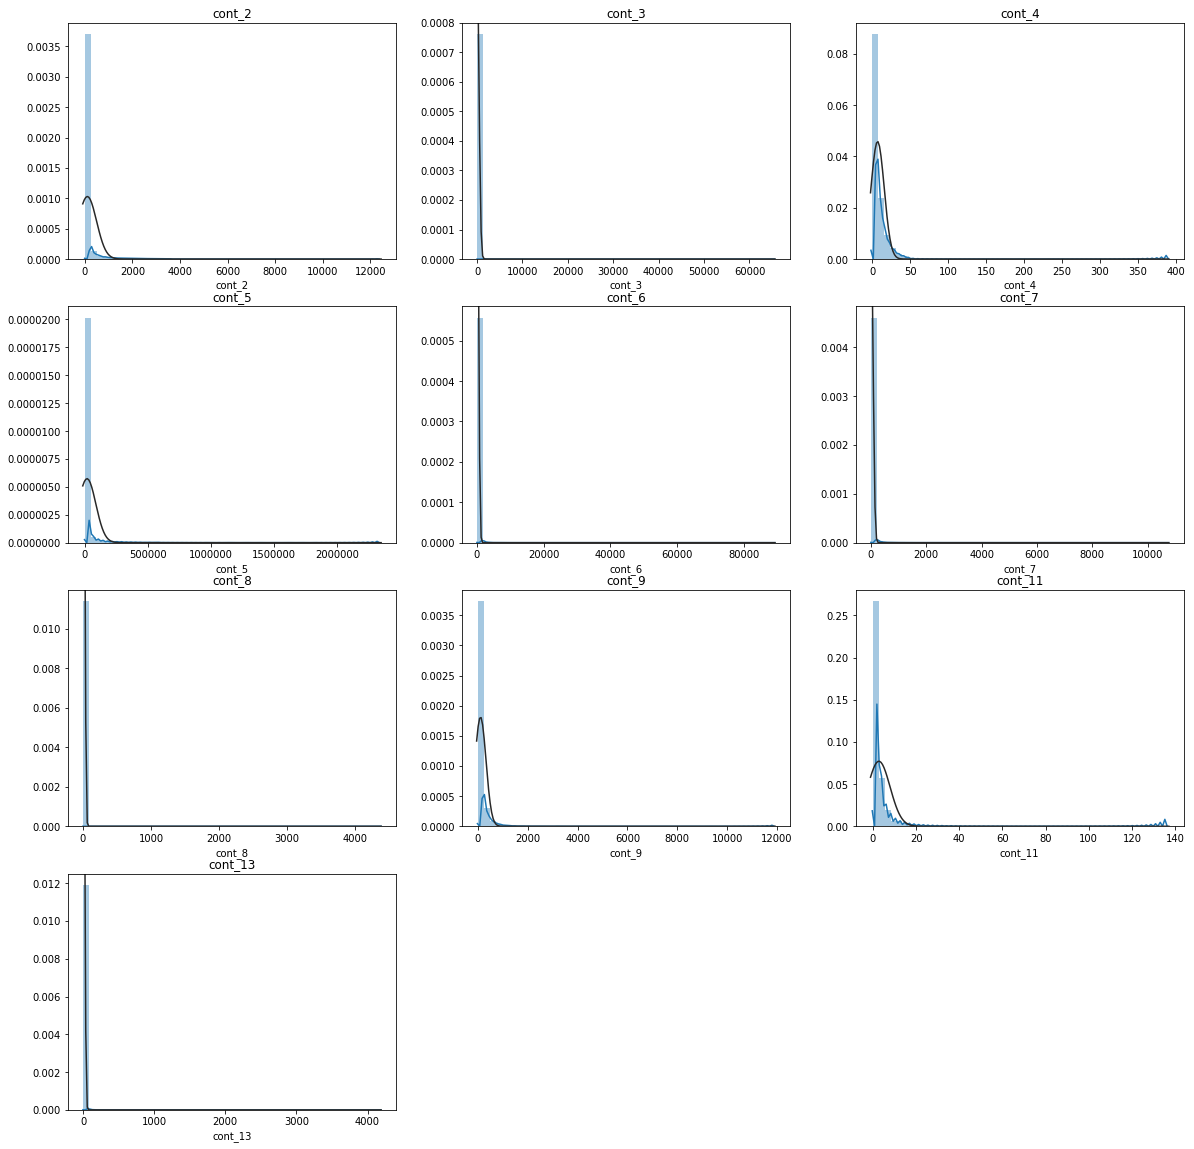

In [8]:
# Creating variables to assist plotting
cont_cols = [i for i in subsample.columns[1:11]]

# For loop to plot continuous variable distribution plots
f, ax = plt.subplots(figsize=(20,20))

for plot, col in zip(range(1,11), cont_cols):
    # Prepare data column for plotting
    to_plot = subsample[col].dropna()            #Drop null values
    
    # Plot column distribution with Gaussian fit line
    plt.subplot(4,3,plot)
    sns.distplot(to_plot, fit=stats.norm)
    plt.title('{}'.format(col))
    
plt.show()

So it doesn't really look like any of our features have a Gaussian distribution. HOWEVER, it does look like many of them may fit a Gamma distribution.

Below we'll replot the distributions with a Gamma fit and while we're at, chop away the largest 10% of all values to help improve visibility.

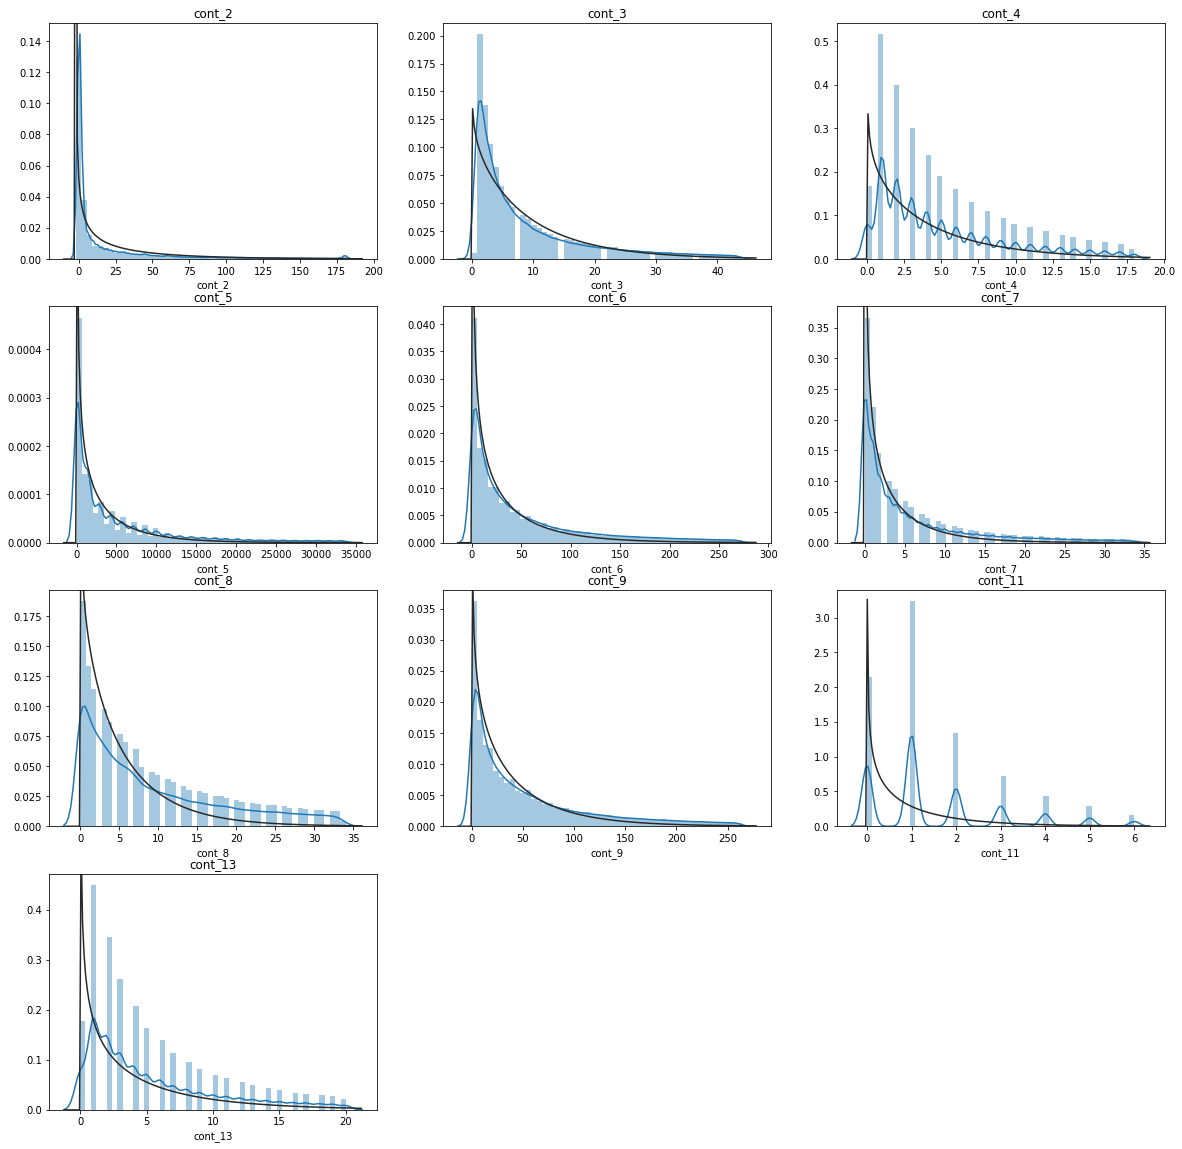

In [9]:
# For loop to plot continuous variable distribution plots
f, ax = plt.subplots(figsize=(20,20))

for plot, col in zip(range(1,11), cont_cols):
    # Prepare data column for plotting
    to_plot = subsample[col].dropna()                          #Drop null values
    to_plot.sort_values(ascending=False, inplace=True)       #Sort data from largest to smallest
    to_plot = to_plot.iloc[(len(to_plot)//10):]               #Drop largest 10% of values
    
    # Plot column distribution with Gamma fit line
    plt.subplot(4,3,plot)
    sns.distplot(to_plot, fit=stats.gamma)
    plt.title('{}'.format(col))
    
plt.show()

The Gamma distribution is a way better descriptor of our continuous data. Now, we just have to run a Naive Bayes model with a Gamma distribution assumption. Problem is, ScikitLearn doesn't offer this functionality. WELP - looks like we're making one from scratch!

In [10]:
def nb_gamma_fit (data):
    ### NOTE: Data must have Y predict at 1st column(index=0)
    
    # Separating Y predict, and feature set into click and non-click classes
    Y = data.iloc[:,0]
    click = data[Y==1].iloc[:,1:]
    non_click = data[Y==0].iloc[:,1:]
    
     # Create empty list to store Probability Density Function for each attribute
    click_pdfs = []
    non_click_pdfs = []
    
    # Loop through each attribute and add respective PDF to list
    for col in click.columns:
        click_pdfs.append(stats.gamma.fit(click[col].dropna()))
        
    for col in non_click.columns:
        non_click_pdfs.append(stats.gamma.fit(non_click[col].dropna()))
    
    
    return (click_pdfs, non_click_pdfs)




def nb_gamma_predict (fit, x):
    ### NOTE: 
    ###     - fit is the return value from nb_gamma_fit function
    ###     - x is a single observation with attribute type equal to original train dataset
    
    # Separate Probability Density Functions for 1(click) and 0(non-click)
    click_pdfs = fit[0]
    non_click_pdfs = fit[1]
    
    # Loop through PDFs and aggregate 
    click_prob = 1
    for pdfs, attr in zip(click_pdfs, x):
        if not math.isnan(attr):
            click_prob = click_prob * stats.gamma.pdf(attr, *pdfs)

    non_click_prob = 1
    for pdfs, attr in zip(non_click_pdfs, x):
        if not math.isnan(attr):
            non_click_prob = non_click_prob * stats.gamma.pdf(attr, *pdfs)
        
    if click_prob > non_click_prob:
        return 1
    else:
        return 0

    

    
def nb_gamma_score_matrix (fit, test_x, test_y):
    ### NOTE: 
    ###     - fit is the return value from nb_gamma_fit function
    ###     - test_x and test_y variables must be the same length
    
    # Set empty confusion matrix
    conf_matrix = [[0,0],[0,0]]
    
    # Loop through all rows and tabulate predictions
    for i in range(len(test_x)):
        y_pred = nb_gamma_predict(fit, test_x.iloc[i])
        y_actual = test_y.iloc[i]
        if y_actual==0 and y_pred==0:
            conf_matrix[0][0] = conf_matrix[0][0] + 1
        elif y_actual==0 and y_pred==1:
            conf_matrix[0][1] = conf_matrix[0][1] + 1
        elif y_actual==1 and y_pred==0:
            conf_matrix[1][0] = conf_matrix[1][0] + 1
        elif y_actual==1 and y_pred==1:
            conf_matrix[1][1] = conf_matrix[1][1] + 1
    
    return np.array(conf_matrix)

In [11]:
# Set variables

nb_data_cont = subsample.loc[:,:'cont_13']
x_test = nb_data_cont.iloc[:,1:]
y_test = nb_data_cont.iloc[:,0]


# Run Naive Bayes model

gamma_fit = nb_gamma_fit(nb_data_cont)
nb_gamma_score = nb_gamma_score_matrix(gamma_fit, x_test, y_test)

print ('Accuracy: {:.1f}%'.format(((nb_gamma_score[1][1]+nb_gamma_score[0][0])/len(nb_data_cont))*100))
print ('Sensitivity: {:.1f}%'.format((nb_gamma_score[1][1]/nb_gamma_score[1].sum())*100))
print ('Specificity: {:.1f}%'.format((nb_gamma_score[0][0]/nb_gamma_score[0].sum())*100))

Accuracy: 64.9%
Sensitivity: 41.7%
Specificity: 73.0%


At our first crack we have an algorithm that has a 70% accuracy rate, which isn't too hot. To add on to that, it does a miserable job of predicting clicks at a rate of only 27%

Let's try one more distribution and see if there are any improvements

In [12]:
# Adjust model for Rayleigh distribution

def nb_rayleigh_fit (data):
    ### NOTE: Data must have Y predict at 1st column(index=0)
    
    # Separating Y predict, and feature set into click and non-click classes
    Y = data.iloc[:,0]
    click = data[Y==1].iloc[:,1:]
    non_click = data[Y==0].iloc[:,1:]
    
     # Create empty list to store Probability Density Function for each attribute
    click_pdfs = []
    non_click_pdfs = []
    
    # Loop through each attribute and add respective PDF to list
    for col in click.columns:
        click_pdfs.append(stats.rayleigh.fit(click[col].dropna()))
        
    for col in non_click.columns:
        non_click_pdfs.append(stats.rayleigh.fit(non_click[col].dropna()))
    
    
    return (click_pdfs, non_click_pdfs)



def nb_rayleigh_predict (fit, x):
    ### NOTE: 
    ###     - fit is the return value from nb_gamma_fit function
    ###     - x is a single observation with attribute type equal to original train dataset
    
    # Separate Probability Density Functions for 1(click) and 0(non-click)
    click_pdfs = fit[0]
    non_click_pdfs = fit[1]
    
    # Loop through PDFs and aggregate 
    click_prob = 1
    for pdfs, attr in zip(click_pdfs, x):
        if not math.isnan(attr):
            click_prob = click_prob * stats.rayleigh.pdf(attr, *pdfs)

    non_click_prob = 1
    for pdfs, attr in zip(non_click_pdfs, x):
        if not math.isnan(attr):
            non_click_prob = non_click_prob * stats.rayleigh.pdf(attr, *pdfs)
        
    if click_prob > non_click_prob:
        return 1
    else:
        return 0

    

    
def nb_rayleigh_score_matrix (fit, test_x, test_y):
    ### NOTE: 
    ###     - fit is the return value from nb_gamma_fit function
    ###     - test_x and test_y variables must be the same length
    
    # Set empty confusion matrix
    conf_matrix = [[0,0],[0,0]]
    
    # Loop through all rows and tabulate predictions
    for i in range(len(test_x)):
        y_pred = nb_rayleigh_predict(fit, test_x.iloc[i])
        y_actual = test_y.iloc[i]
        if y_actual==0 and y_pred==0:
            conf_matrix[0][0] = conf_matrix[0][0] + 1
        elif y_actual==0 and y_pred==1:
            conf_matrix[0][1] = conf_matrix[0][1] + 1
        elif y_actual==1 and y_pred==0:
            conf_matrix[1][0] = conf_matrix[1][0] + 1
        elif y_actual==1 and y_pred==1:
            conf_matrix[1][1] = conf_matrix[1][1] + 1
    
    return np.array(conf_matrix)

In [13]:
# Run model

rayleigh_fit = nb_rayleigh_fit(nb_data_cont)
nb_rayleigh_score = nb_rayleigh_score_matrix(rayleigh_fit, x_test, y_test)

print ('Accuracy: {:.1f}%'.format(((nb_rayleigh_score[1][1]+nb_rayleigh_score[0][0])/len(nb_data_cont))*100))
print ('Sensitivity: {:.1f}%'.format((nb_rayleigh_score[1][1]/nb_rayleigh_score[1].sum())*100))
print ('Specificity: {:.1f}%'.format((nb_rayleigh_score[0][0]/nb_rayleigh_score[0].sum())*100))

Accuracy: 63.5%
Sensitivity: 55.1%
Specificity: 66.5%


Yikes, even worse. Maybe the problem is that the null values aren't random? Perhaps they have some predictive power? We can test this using a Bernoulli Naive Bayes model on our categorical variables.

First, let's review our variables to see which ones have a reasonable amount of categories (we don't want the whole kernel shutting down due to RAM limitations!)

In [14]:
# Creating variables to assist in manipulation
catg_cols = [i for i in unedited.columns[14:]]

for col in catg_cols:
    print('{} values: {}'.format(col, len(unedited[col].unique())))

catg_1 values: 1014
catg_2 values: 543
catg_3 values: 181411
catg_4 values: 79708
catg_5 values: 231
catg_6 values: 13
catg_7 values: 10423
catg_8 values: 460
catg_9 values: 3
catg_10 values: 23395
catg_11 values: 4641
catg_12 values: 163216
catg_13 values: 3105
catg_14 values: 26
catg_15 values: 8016
catg_16 values: 128442
catg_17 values: 10
catg_18 values: 3574
catg_19 values: 1693
catg_20 values: 4
catg_21 values: 148662
catg_22 values: 13
catg_23 values: 14
catg_24 values: 29443
catg_25 values: 67
catg_26 values: 21933


Most of the features have too many unique categories for us to create dummies. What we can do is set up some dummy features for all the columns that have less than 100 unique values and see what kind of results we get from that.

We'll also integrate null values as an additional category in each of our variables. This way, the model will account for any predictive power missingness might have.

In [15]:
# Set variables

nb_data_catg = unedited.loc[:,'catg_1':]
x_test = pd.get_dummies(nb_data_catg[['catg_6','catg_9','catg_14','catg_17','catg_20','catg_23','catg_25']], dummy_na=True)
y_test = nb_data_catg.iloc[:,0]

# Run Bernoulli Naive Bayes
from sklearn.naive_bayes import BernoulliNB as BNB

bnb = BNB()
bnb.fit(x_test, y_test)
bnb.score(x_test, y_test)

0.4997011382922562

Not very good either. Guess we'll have to try and see if we can pull out the big guns.

**Potential improvements**:
- More RAM so we can process the entire dataset at once
- Optimizing hand written Naive Bayes algorithm using arrays so that it runs faster
- Testing for feature independence

### KNN

Next up is our KNearestNeighbors algorithm. This is generally a very good classifier, but were it's also quite beneficial is in imputing values.

SKLearn doesn't have some of these more advanced capabilities, so we'll take advantage of some open source code for our purposes here.

In [ ]:
# Importing KNN imputation function

from knn_impute import knn_impute

unedited_sample = unedited.sample(frac=.05, axis=0)
unedited_sample.shape

In [ ]:
null_reorder_dict = unedited_sample.isnull().sum()
reorder_index = null_reorder_dict.sort_values().index
unedited_sample = unedited_sample.reindex_axis(reorder_index, axis=1)
unedited_sample = unedited_sample.iloc[:,1:]

In [ ]:
# Separating data that has no null values from data that needs to be imputed

imputed_dataset = unedited_sample.iloc[:,:15]
data_to_impute = unedited_sample.iloc[:,15:]

imputed_dataset['cont_8'] = knn_impute(target=data_to_impute['cont_8'],
                                       attributes=imputed_dataset,
                                       aggregation_method='mean',
                                       k_neighbors=8,
                                       numeric_distance='cityblock',
                                       categorical_distance='jaccard',
                                       missing_neighbors_threshold=0.8
                                      )

Essentially, our borrowed piece of code takes a **target** dataframe column to fill, along with a set of **attributes** to determine distance. It then fills the null value by aggregating a set of specified closest **k_neighbors**, using specified **aggregation** and **distance** methods.


Decisions on determing imputed value were as follows calculations are slightly different depending on data type:

**K_Neighbors** (k=8):
- There are generally 2 buckets for selecting neighbors - (3-10) or (50-100). We decided to keep the k-value in the lower end of the spectrum to bias the local predictive effects and create cleaner clusters for our predictive model
    

**Distance**:
- For *categorical variables* we used the Weighted Hamming distance. Because some of our categorical variables have very many categories, adding weighting by frequency of category will allow for more accurate imputed values.
- For *continuous variables* we used the standard Euclidean distance - the algorithm normalizes data prior to calculating


**Aggregation**:
- For *categorical variables* we used mode
- For *continuous variables* we used mean
___________________

*Sources*


- Git: https://gist.github.com/YohanObadia/b310793cd22a4427faaadd9c381a5850
- Article: https://towardsdatascience.com/the-use-of-knn-for-missing-values-cf33d935c637

In [ ]:
# Setting up separate data set for imputing - excluding categorical variables with too many categories

df = pd.concat([unedited.loc[:,'cont_1':'cont_13'], unedited[['catg_6','catg_9','catg_14','catg_17','catg_20','catg_23','catg_25']]], axis=1)


# Reordering dataset columns in ascending order from least to most null values

null_reorder_dict = df.isnull().sum()
reorder_index = null_reorder_dict.sort_values().index
df = df.reindex_axis(reorder_index, axis=1)

In [ ]:
# Separating data that has no null values from data that needs to be imputed

imputed_dataset = df.iloc[:,:5]
data_to_impute = df.iloc[:,5:]


# Loop through and impute all missing data 

imputed_dataset['cont_8'] = knn_impute(target=data_to_impute['cont_8'],
                                       attributes=imputed_dataset,
                                       aggregation_method='mean',
                                       k_neighbors=8,
                                       numeric_distance='cityblock',
                                       categorical_distance='weighted-hamming',
                                       missing_neighbors_threshold=0.8
                                      )

In [ ]:
data_to_impute.dtypes

In [ ]:
for col in data_to_impute.columns:
    if dtype(data_to_impute[col])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNN

#Separate data into continuous only and all
knn_cont = 
knn_all = 

knn = KNN(n_neighbors=50)

knn.fit(x_test, y_test)
knn.score(x_test, y_test)

### Random Forest

A more precise, but undoubtedly more intensive, modeling technique to use here would be a random forest. The benefit of a random forest is that 

In [ ]:
rf_data = unedited[:]
rf_data_cont = rf_data.loc[:,'cont_1':'cont_13'].fillna(value=-999)
rf_data_catg = rf_data.loc[:,'catg_1':].fillna(value='MISSING')

rf_data = pd.concat([rf_data.iloc[:,0], rf_data_cont, rf_data_catg], axis=1)
rf_data.head()

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import cross_val_score

rfc = RFC(n_estimators=50, max_depth=10, min_samples_leaf=200)

X = rf_data_cont
Y = rf_data.iloc[:,0]
print(cross_val_score(rfc, X, Y, cv=5))